# Get the Corpus and  put it into Chapter Files

### Project Gutenberg helps us out here. 

In [119]:
%%bash
data_dir="/home/daniel/git/Python2.7/DataScience/nlp_training_data"

curl -s http://www.gutenberg.org/cache/epub/28885/pg28885.txt > ${data_dir}/alice.txt

In [120]:
%%bash
# the magic "%%bash" doesn't remember the shell parameter
data_dir="/home/daniel/git/Python2.7/DataScience/nlp_training_data"

# grep to find chapter start lines
grep -in "chapter" ${data_dir}/alice.txt

212:CHAPTER I
422:CHAPTER II
632:CHAPTER III
891:CHAPTER IV
1160:CHAPTER V
1461:CHAPTER VI
1792:CHAPTER VII
2137:CHAPTER VIII
2454:CHAPTER IX
2778:CHAPTER X
3077:CHAPTER XI
3343:CHAPTER XII


In [121]:
%%bash
# the magic "%%bash" doesn't remember the shell parameter
data_dir="/home/daniel/git/Python2.7/DataScience/nlp_training_data"

# parse out the line number, cut has option "-d" for delimiter, "-f1"  field 1
grep -in "chapter" ${data_dir}/alice.txt | cut -d: -f1

212
422
632
891
1160
1461
1792
2137
2454
2778
3077
3343


In [122]:
%%bash
# the magic "%%bash" doesn't remember the shell parameter
data_dir="/home/daniel/git/Python2.7/DataScience/nlp_training_data"

# all together
grep -in "chapter" ${data_dir}/alice.txt | cut -d: -f1 > ${data_dir}/alice_chap_nums.txt
# don't forget the end of the book
grep -in "the end" ${data_dir}/alice.txt | tail -n 1 | cut -d: -f1 >> ${data_dir}/alice_chap_nums.txt

cat ${data_dir}/alice_chap_nums.txt

212
422
632
891
1160
1461
1792
2137
2454
2778
3077
3343
3637


In [123]:
# zsh method for creating the chapter files

#array=$("{$(@f)$(<$data_dir/alice_chap_nums.txt)}")

#n=${#array[@]}

#for i in {1..$n};do
#    start=$array[i]
#    next=$(($i+1))
#    end=$(($array[$next])-1))
#    
#    fname=$(print "chap_%02i.txt" $i)
#    sed -n "$start,${end}p" ${data_dir}/alice.txt > $fname

In [124]:
import numpy as np
from os import path
import codecs

data_dir = "/home/daniel/git/Python2.7/DataScience/nlp_training_data"

chap_line_nums = np.loadtxt(path.join(data_dir, 'alice_chap_nums.txt'), dtype='int', delimiter='\n')

f = codecs.open(path.join(data_dir,'alice.txt'), 'r', encoding='utf-8')
lines = f.readlines()
f.close()
     
print chap_line_nums

[ 212  422  632  891 1160 1461 1792 2137 2454 2778 3077 3343 3637]


## Parse into sentences and join them into rough paragraphs.

In [125]:
for i in range(chap_line_nums.size - 1):
    chap_num = i + 1
    f = codecs.open(path.join(data_dir,'chap_%02i.txt' %chap_num), 'w', encoding='utf-8')
    
    start = chap_line_nums[i]
    end = chap_line_nums[i+1] - 1

    for line in lines[start:end]:
        f.write(line) 
    
    f.close()
    

In [126]:
import glob

chps = glob.glob(path.join(data_dir,"chap_*.txt"))
chps.sort()

for ch in chps:
    print ch

/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_01.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_02.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_03.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_04.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_05.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_06.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_07.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_08.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_09.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_10.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_11.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_12.txt


# NLP
### Helper Functions for my own naive text pre-processing

In [127]:
from nltk import tokenize, stem
import nltk
import re

In [128]:
def get_chap_sents(filename):
    f = codecs.open(filename, 'r', encoding='utf-8')
    lines = f.read()
    f.close()

    sents = tokenize.sent_tokenize(lines)
    sents = map(lambda s:s.replace('\r\n',' '), sents)
    sents = map(lambda s:s.replace('_',''), sents)
    sents = map(lambda s:s.replace(',',' '), sents)
    
    return sents

def join_n_sentences(sentences, n=6):
    new_lines = []
    num_sent = len(sentences)
    index = np.arange(0, num_sent, n)
    
    for i in index:
        concat_lines = ' '.join(sentences[i:i+n+1])
        new_lines.append(concat_lines)
        
    return new_lines    

def build_docs(filename):
    sents = get_chap_sents(filename)
    doc = join_n_sentences(sents)
    
    return doc

def get_nltk_pos(string):
    string = tokenize.word_tokenize(string)
    pos = nltk.pos_tag(string)
    
    return pos

#pat = "^[NVJR]"
pat = "^[NV]"
reg = re.compile(pat)
def filter_pos(pos):
    out = []
    for item in pos:
        if reg.match(item[1]):
            out.append(item[0])
            
    return out        

def get_pos(doc):
    out = []
    for string in doc:
        pos = get_nltk_pos(string)
        #print pos
        temp = filter_pos(pos)
        string = ' '.join(temp)
        out.append(string)
    
    #out = [item for sub_list in out for item in sub_list]
    return out

def remove_short_words(pos, num_letters=2):
    out = []
    for word in pos.split(' '):
        if len(word) < num_letters:
            continue
        else:
            out.append(word)
         
    return ' '.join(out)    

stem_obj = stem.SnowballStemmer('english')
def stemmer(doc):
    words = tokenize.word_tokenize(doc)
    stems = map(stem_obj.stem, words)
    new_doc = " ".join(stems)
    
    return new_doc

# Borrowed Grammar Code
### For more advanced text pre-processing
#### Borrowed with slight modifications from:  https://gist.github.com/alexbowe/879414#file-nltk-intro-py-L34

In [129]:
# https://gist.github.com/alexbowe/879414#file-nltk-intro-py-L34
from nltk.corpus import stopwords

stopwords = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()
stemmer_alt = nltk.stem.porter.PorterStemmer()

# Used when tokenizing words
sentence_re = r'''(?x)      # set flag to allow verbose regexps
      ([A-Z])(\.[A-Z])+\.?  # abbreviations, e.g. U.S.A.
    | \w+(-\w+)*            # words with optional internal hyphens
    | \$?\d+(\.\d+)?%?      # currency and percentages, e.g. $12.40, 82%
    | \.\.\.                # ellipsis
    | [][.,;"'?():-_`]      # these are separate tokens
'''
# Grammar is from: S. N. Kim, T. Baldwin, and M.-Y. Kan. 
# Evaluating n-gram based evaluation metrics for automatic keyphrase extraction. 
# Technical report, University of Melbourne, Melbourne 2010.

grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns

    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""


class Alternate(object):
    
    def leaves(self, tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter=lambda t:t.label() == 'NP'):
            yield subtree.leaves()

    def normalise(self, word):
        """Normalises words to lowercase and stems and lemmatizes it."""
        word = word.lower()
        word = stemmer_alt.stem_word(word)
        word = lemmatizer.lemmatize(word)
        
        return word

    def acceptable_word(self, word):
        """Checks conditions for acceptable word: length, stopword."""
        accepted = bool(2 <= len(word) <= 20
            and word.lower() not in stopwords)
        
        return accepted

    def get_terms(self, tree):
        for leaf in self.leaves(tree):
            term = [ self.normalise(w) for w,_ in leaf if self.acceptable_word(w) ]
            
            yield term
            
    def get_words(self, terms):
        out = []
        for term in terms:
            for word in term:
                out.append(word)
        
        return " ".join(out)
            
    def main(self, text):
        chunker = nltk.RegexpParser(grammar)

        toks = nltk.regexp_tokenize(text, sentence_re)
        postoks = nltk.tag.pos_tag(toks)

        #print postoks
        tree = chunker.parse(postoks)

        terms = self.get_terms(tree)
        
        words = self.get_words(terms)

        return words

# Comparison of Grammar Method and My Own Simplistic

In [130]:
docs = build_docs(chps[0])
print docs[3] 
print '\n' + str(len(docs)) + " sentences in the doc" + '\nAfter pre-processing:\n'
docs = map(remove_short_words, docs)
docs = map(stemmer, docs)
print docs[3]

Would the fall never come to an end? "I wonder how many miles I've fallen by this time?" she said aloud. "I must be getting somewhere near the centre of the earth. Let me see: that would be four thousand miles down. I think--" (for  you see  Alice had learnt several things of this sort in her lessons in the schoolroom  and though this was not a very good opportunity for showing off her knowledge  as there was no one to listen to her  still it was good practice to say it over) "--yes  that's about the right distance--but then I wonder what Latitude or Longitude I've got to?" (Alice had no idea what Latitude was  or Longitude either  but thought they were nice grand words to say.)

15 sentences in the doc
After pre-processing:

would the fall never come to an end ? `` i wonder how mani mile i ve fallen by this time ? '' she said aloud . `` i must be get somewher near the centr of the earth . let me see : that would be four thousand mile down . think -- '' ( for you see alic had learnt se

###  Add POS tags, taking only Nouns and Verbs

In [131]:
docs = get_pos(docs)
print docs[3]

fall come end wonder mani mile ve fallen time said be get centr let see be thousand mile think see had learnt thing sort lesson schoolroom was veri opportun show knowledg was one listen was say yes 's right distanc latitud longitud ve got had idea latitud was longitud thought were grand word say


## Grammar sample

In [132]:
alt = Alternate()
docs = build_docs(chps[0])
docs = map(alt.main, docs)
print docs[3]

fall end mani mile time centr let thousand mile alic sever thing sort lesson schoolroom good opportun show knowledg one good practic ye right distanc latitud longitud ve got alic idea latitud longitud nice grand word


# Build the Full Demo

In [133]:
import pandas as pd
df = pd.DataFrame()

df['doc'] = docs
df['chap'] = np.ones(df.doc.count())
df

,doc,chap
0,sidenot rabbit-hol alic sit sister bank noth t...,1
1,moment went alic world rabbit-hol went tunnel ...,1
2,alic fall noth stair ll think home anyth hous ...,1
3,fall end mani mile time centr let thousand mil...,1
4,alic idea latitud longitud nice grand word ear...,1
5,fanci curtsey re air ignor littl girl ll ll no...,1
6,dinah ll miss dinah cat ll rememb saucer milk ...,1
7,alic went dreami sort way cat bat cat bat bat ...,1
8,thump heap stick dri leav fall alic bit hurt f...,1
9,three-leg tabl solid glass noth tini golden ke...,1


In [135]:
for ind, _file in enumerate(chps[1:], start=2):
    docs = build_docs(_file)
    docs = map(alt.main, docs)

### 
#     Home made simplistic non-grammar below, performs OK
#     docs = map(remove_short_words, docs)
#     docs = map(stemmer, docs)
#     docs = get_pos(docs)
###

    n = len(docs)
    temp = pd.DataFrame({ 'doc':docs, 'chap':np.ones(n)*ind })
    df = pd.concat([df, temp], axis=0)


# Feature Extraction / Vectorization

In [136]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS

In [137]:
grp = df.groupby('chap')
cnts = grp.chap.count()
_sum = grp.chap.count().sum()
mu = grp.chap.count().mean()

print cnts, "\n total", _sum, "\n mean", mu

chap
1     15
2     20
3     20
4     25
5     23
6     25
7     30
8     24
9     28
10    26
11    21
12    20
Name: chap, dtype: int64 
 total 277 
 mean 23.0833333333


In [184]:
additional_stop_words = ['chapter', 'illustration', 'alice', 'sidenote']
# don't forget to run the stemmer on the additional stop words
additional_stop_words = map(stem_obj.stem, additional_stop_words)
stop_words = ENGLISH_STOP_WORDS.union(additional_stop_words)
print additional_stop_words

[u'chapter', u'illustr', u'alic', u'sidenot']


In [185]:
min_df = cnts.min() - 3
max_df = np.floor(cnts.mean() * 3)

In [186]:
vectorizer = TfidfVectorizer(max_features=150,
                             lowercase=True,
                             max_df=max_df,
                             min_df=min_df,
                             use_idf=True,
                             stop_words=stop_words,
                             norm='l2',
                             ngram_range=(1, 2),
                             analyzer='word',
                             decode_error='ignore',
                             strip_accents='unicode'
                            )

In [187]:
# vectorizer = CountVectorizer(max_features=100,
#                              lowercase=True,
#                              max_df=35,
#                              min_df=10,
#                              stop_words='english',
#                              ngram_range=(1, 2),
#                              analyzer='word',
#                              decode_error='ignore',
#                              strip_accents='unicode'
#                              )

In [188]:
matrix = vectorizer.fit_transform(df['doc'])
features = vectorizer.get_feature_names()      

print matrix.shape 
print features
# vectorize the "docs"
# kmeans and store cluster in df

(277, 100)
[u'air', u'anyth', u'arm', u'bit', u'cat', u'caterpillar', u'child', u'come', u'cours', u'court', u'creatur', u'curiou', u'day', u'deal', u'dear', u'door', u'dormous', u'duchess', u'end', u'everyth', u'evid', u'eye', u'face', u'foot', u'game', u'garden', u'glass', u'good', u'great', u'gryphon', u'half', u'hand', u'hare', u'hatter', u'head', u'hous', u'hurri', u'idea', u'juri', u'king', u'larg', u'lesson', u'let', u'littl', u'll', u'long', u'look', u'low', u'majesti', u'mani', u'march', u'march hare', u'matter', u'mind', u'minut', u'mock', u'mock turtl', u'moment', u'mous', u'mouth', u'noth', u'oh', u'old', u'peopl', u'plea', u'pool', u'poor', u'queen', u'question', u'rabbit', u'reason', u'right', u'round', u'sight', u'silenc', u'size', u'someth', u'sort', u'sure', u'tabl', u'talk', u'tea', u'tear', u'tell', u'thing', u'thought', u'till', u'time', u'tone', u'tree', u'turn', u'turtl', u'use', u've', u'voic', u'way', u'white', u'white rabbit', u'word', u'ye']


In [189]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances
from sklearn.cluster import KMeans
from sklearn import metrics

## Cosine Similarity is a fancy way of talking about a correlational, or dot product relationship.

Recall that an dot product between vectors is a scalar and is defined:


$$    \mathbf A \cdot \mathbf B = \left\| \mathbf A \right\| \, \left\| \mathbf B \right\| \cos \theta $$

In [190]:
cos_sim = cosine_similarity(matrix)
cos_sim.shape

(277, 277)

## We'd like to see clusters about the diagonal
Bright spots away from the diagonal mean that a "document", or chunk
of sentences, are correlating with a chunk from far away.

<matplotlib.colorbar.Colorbar instance at 0x7fb13ecc58c0>

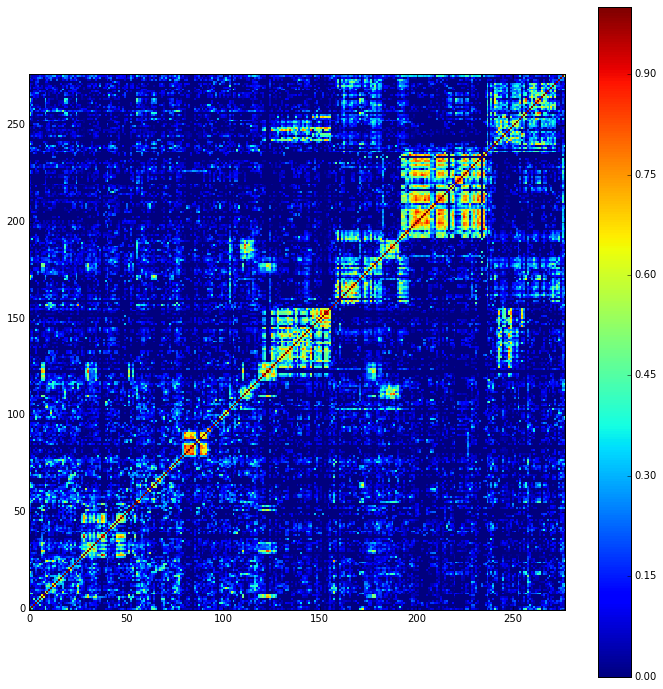

In [191]:
%matplotlib inline
plt.figure(figsize=(12, 12))
plt.imshow(cos_sim, origin='lower', interpolation='nearest')
plt.colorbar()

## K means operates on a distance measure.
Sometimes it's useful to use the "cosine" distance.

### Cosine Distance is: 1 - cosine-similarity

Cosine Similarity of two vectors is the relative projection of each vector onto every other vector. I've called this the normalized covariance matrix or, correlation matric, in my other work. It's an "outer product", where the dimensions are increased, rather than an inner product where the dimensions are collasped.

In [192]:
cos_dist = cosine_distances(matrix)
euc_dist = euclidean_distances(matrix)

In [193]:
# Here I use the Euclidean Distance but you can try the Cosine 
k = len(chps)
km = KMeans(k,
            init='random',
            #init='k-means++', 
            n_init=100, 
            max_iter=1000, 
            tol=1e-7, 
            precompute_distances=True, 
            verbose=0, 
            random_state=1, 
            copy_x=True,
            n_jobs=4
            )

assignments = km.fit_predict(euc_dist)
print np.unique(assignments)

[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [194]:
df['cluster_chaps'] = assignments + 1

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html#sklearn.metrics.homogeneity_score

Homogeneity metric of a cluster labeling given a ground truth
A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.
This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way.

In [195]:
metrics.homogeneity_score(df.chap, df.cluster_chaps)

0.52334165289784107

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html#sklearn.metrics.completeness_score

Completeness metric of a cluster labeling given a ground truth
A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.
This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way.

In [196]:
metrics.completeness_score(df.chap, df.cluster_chaps)

0.56558180115777923

## Visualise the distributions of the learned clusters
Here I use Histograms to visualize the amount of overlap between the 
learned clusters. Ideally, I'd want to see one bin per document. But I'd settle for one large peak in a bin, where the others where short. 

chap
1     [[Axes(0.125,0.125;0.775x0.775)]]
2     [[Axes(0.125,0.125;0.775x0.775)]]
3     [[Axes(0.125,0.125;0.775x0.775)]]
4     [[Axes(0.125,0.125;0.775x0.775)]]
5     [[Axes(0.125,0.125;0.775x0.775)]]
6     [[Axes(0.125,0.125;0.775x0.775)]]
7     [[Axes(0.125,0.125;0.775x0.775)]]
8     [[Axes(0.125,0.125;0.775x0.775)]]
9     [[Axes(0.125,0.125;0.775x0.775)]]
10    [[Axes(0.125,0.125;0.775x0.775)]]
11    [[Axes(0.125,0.125;0.775x0.775)]]
12    [[Axes(0.125,0.125;0.775x0.775)]]
dtype: object

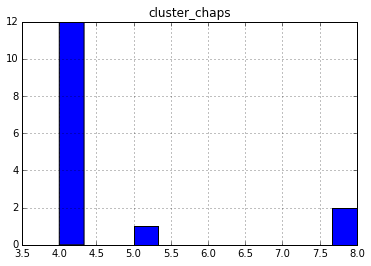

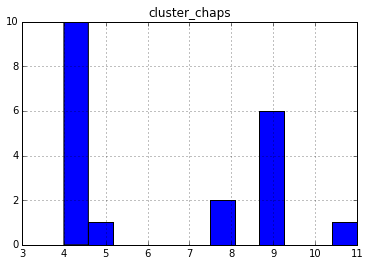

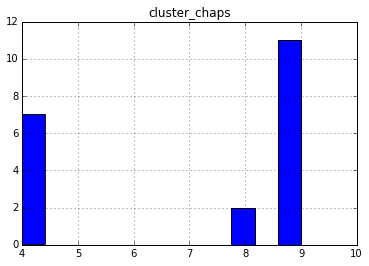

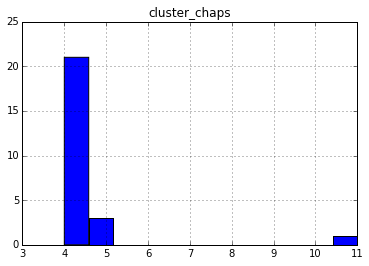

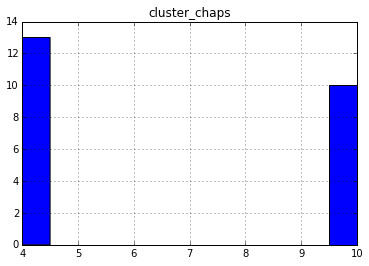

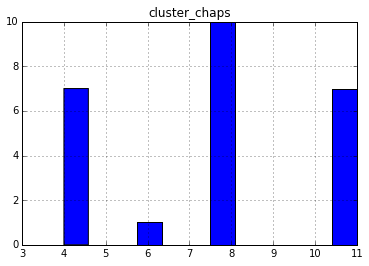

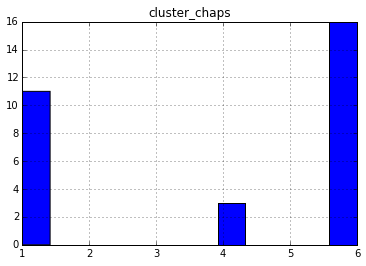

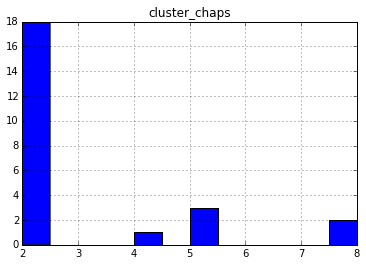

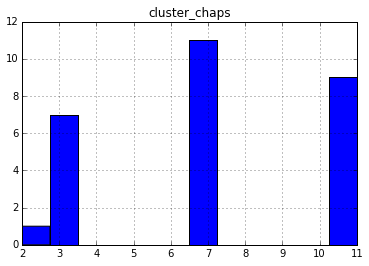

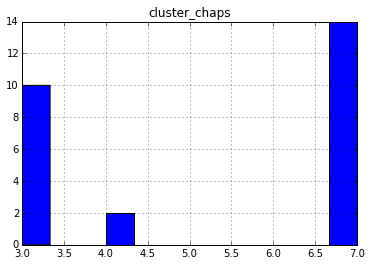

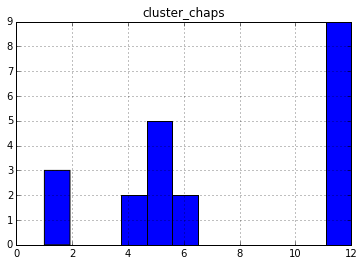

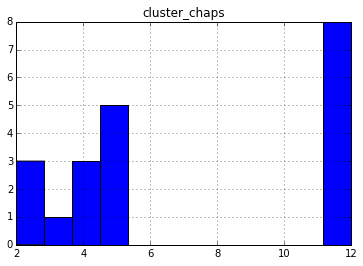

In [197]:
%matplotlib inline
grp = df.groupby('chap')
grp.hist(bins=k)

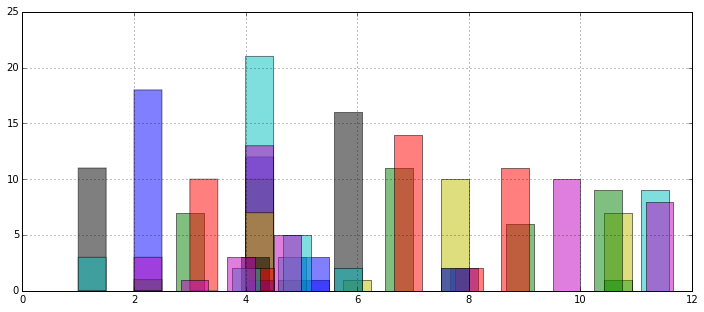

In [198]:
for i in range(1, k+1):
    df[df.chap == i]['cluster_chaps'].hist(figsize=(12,5), alpha=0.5, width=0.5, bins=k)

## Supervised Learning, Just for Fun

In [199]:
from sklearn.cross_validation import train_test_split
X = matrix
y = df.chap

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)
y = np.ravel(y)

In [200]:
print X_train.shape, X_test.shape

(193, 100) (84, 100)


In [207]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix as sk_confusion_matrix

clf = RandomForestClassifier(n_estimators=10, 
                             criterion='gini', 
                             max_depth=8, 
                             random_state=1
                            )
                            
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print "Accuracy:", metrics.accuracy_score(y_test, y_pred)

Accuracy: 0.535714285714


In [208]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline 

clf_test = Pipeline([
                ('feature_selection', LinearSVC(penalty="l1", dual=False)),
                ('classification', clf)
               ])

clf_test.fit(X_train, y_train)
y_pred = clf_test.predict(X_test)
print "Accuracy:", metrics.accuracy_score(y_test, y_pred)

Accuracy: 0.5


## Confusion Matrix

I think of a confusion matrix as the covariance matrix, with the
predicted outcomes along the rows, and the true labels along the columns.

In [209]:
def confusion_matrix(y_test, y_pred):
    cm = sk_confusion_matrix(y_test, y_pred)
    error_rate = (y_pred != y_test).mean()
    
    return cm

(12, 12)


<matplotlib.colorbar.Colorbar instance at 0x7fb13dca7050>

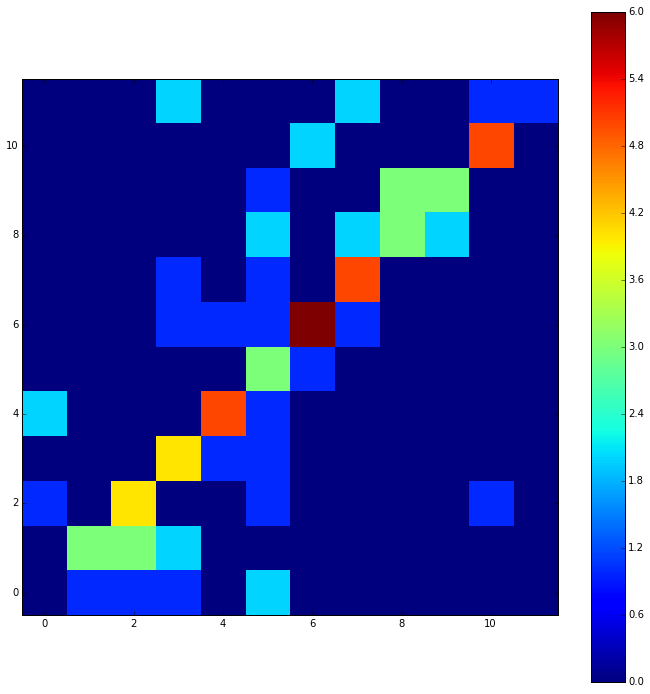

In [210]:
cm = confusion_matrix(y_test, y_pred)
print cm.shape
plt.figure(figsize=(12, 12))
plt.imshow(cm, origin='lower', interpolation='nearest')
plt.colorbar()

## Feature Analysis

Random Forest has the nice attribute that is returns the "important" features.

In [211]:
importances = clf.feature_importances_
print "Num of import vectors:", importances.size
indices = np.argsort(importances)[0:15]

inverse_features = vectorizer.inverse_transform(matrix)
print "Num of feature vectors", len(inverse_features)

Num of import vectors: 94
Num of feature vectors 277


In [212]:
for i in range(indices.size):
    string = "Rank %(rank)i:\n %(features)s\n"
    words = ", ".join(inverse_features[indices[i]])
    string = string %{"rank":i+1,
                     "features":words
                     }
    print string
#fea_name = np.array(features)[indices]
#fea_names = np.array(features)[indices]

Rank 1:
 old, juri, someth, come, look, long, mous, idea, ve, let, hous, ll, dear, noth

Rank 2:
 caterpillar, reason, come, question, good, mind

Rank 3:
 silenc, minut, face, littl, ll, moment, rabbit

Rank 4:
 reason, till, someth, voic, glass, round, door, hand, air, sort, hous, ll, anyth, rabbit

Rank 5:
 arm, minut, poor, round, door, littl, head, sort, foot, rabbit

Rank 6:
 someth, larg, half, door, littl, head, word, thing, ll, anyth, time

Rank 7:
 tone, long, head, word, thing, foot

Rank 8:
 tone, question, mous, thing, dear

Rank 9:
 everyth, talk, voic, low, ve, thing, time, dear, white, rabbit

Rank 10:
 deal, great, let, ll, foot, way

Rank 11:
 deal, sure, pool, tear, poor, great, sight, good, moment, foot, oh, way

Rank 12:
 mouth, tone, deal, come, bit, hand, head, good, moment, foot, time

Rank 13:
 minut, size, thought, face, curiou, garden, door, littl, right, thing

Rank 14:
 tell, hand, question, cat, sort, way

Rank 15:
 old, voic, minut, lesson, ll, oh, way

